# 00. Import Library

In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from keras_ocr.detection import Detector
from PIL import Image, ImageDraw

from IPython.display import display

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

# 01. Data load & display

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


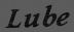

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


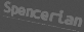

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


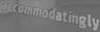

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


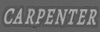

In [2]:
# env에 데이터 로드
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 높이가 32로 일정한 이미지와 라벨을 함께 출력      
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

# 02. Data preprocessing
## Purpose of MJDatasetSequence class
### 1. 이미지 크기 조정
### 2. label encoding
### 3. input shape 조정
### 4. 배치 단위로 image load
### 5. sequence 사용을 통한 multi processing

In [3]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

## Purpose of LabelConverter class
### 1. 각 Charater를 class로 정의
### 2. 텍스트를 숫자로 인코딩
### 3. 숫자 시퀀스를 텍스트로 디코딩

In [4]:
class LabelConverter(object):
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [8]:
# 영어 대문자와 숫자만 정의
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

label_converter = LabelConverter(TARGET_CHARACTERS)

In [9]:
# CTC loss를 계산하기 위한 Lambda 함수
def ctc_lambda_func(args): 
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### CTC: 음성인식이나 문자인식에서 target과 output seq의 길이가 다를 때 (output > target) loss function 정의하는 방법
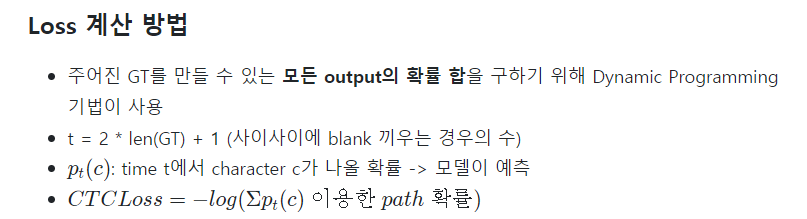

# 03. Build model - CRNN 

In [47]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = tf.keras.layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = tf.keras.layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = tf.keras.layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = tf.keras.layers.Reshape(target_shape=(24, 512))(feature)
    
    sequnce = tf.keras.layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Dropout(0.3)(sequnce) 
    
    sequnce = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(sequnce)
    
    sequnce = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Dropout(0.3)(sequnce)
    
    y_pred = tf.keras.layers.Dense(num_chars, activation='softmax', name='output')(sequnce)
    
    labels = tf.keras.layers.Input(shape=[22], dtype='int64', name='label')
    input_length = tf.keras.layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = tf.keras.layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = tf.keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = tf.keras.models.Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [48]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 50, 16, 64)   0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 50, 16, 128)  73856       max_pooling2d_16[0][0]           
____________________________________________________________________________________________

# 04. Train

## 04_1. datasets & model

In [53]:
# 데이터셋과 모델을 준비
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

## 04_2. compile

In [54]:
# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

## 04_3. callbacks

In [55]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 8
    lrate = initial_lrate * (drop ** np.floor((1 + epoch) / epochs_drop))
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

## 04_4. fit

In [56]:
history = model.fit(train_set,
              steps_per_epoch=len(train_set),
              epochs=30,
              validation_data=val_set,
              validation_steps=len(val_set),
              callbacks = [ckp, earlystop, lrate]
    )

Epoch 1/30
565/565 [==============================] - 92s 151ms/step - loss: 25.7483 - val_loss: 23.4425

Epoch 00001: val_loss improved from inf to 23.44254, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/30
565/565 [==============================] - 84s 149ms/step - loss: 16.7563 - val_loss: 12.2660

Epoch 00002: val_loss improved from 23.44254 to 12.26595, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/30
565/565 [==============================] - 84s 149ms/step - loss: 8.8085 - val_loss: 7.3273

Epoch 00003: val_loss improved from 12.26595 to 7.32735, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/30
565/565 [==============================] - 84s 148ms/step - loss: 6.4969 - val_loss: 5.7705

Epoch 00004: val_loss improved from 7.32735 to 5.77055, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/30
565/565 [==============================] - 84s 148ms/step - loss: 5.3117 - val_loss: 5.2128

Epoch 00005: val_loss im

## 04_5. Visualization loss

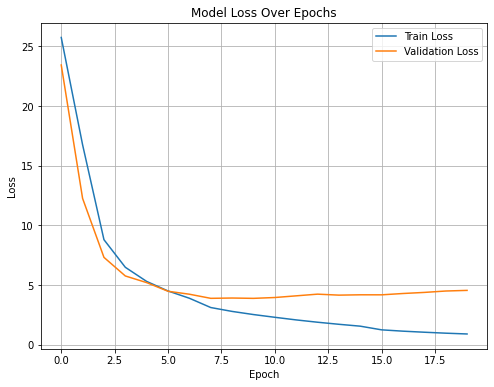

In [57]:
# 손실 값 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# 05. OCR evaluation
## detection =>  keras_ocr
## recognition => CRNN model 

## 05_1. sample image load

In [58]:
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

## 05_2. Detection

In [59]:
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [60]:
# Load the pre-trained model
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
model = build_crnn_model()
model.load_weights(checkpoint_path)

In [61]:
# Create inference model
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [62]:
def decode_predict_ctc(out, chars=TARGET_CHARACTERS):
    results = []
    char_list = list(chars)
    input_length = np.ones(out.shape[0]) * out.shape[1]

    decoded = tf.keras.backend.ctc_decode(out, input_length=input_length, greedy=True)[0][0]
    decoded_indices = tf.keras.backend.get_value(decoded)
    for indices in decoded_indices:
        text = ''.join([char_list[index] for index in indices if index < len(char_list)])
        results.append(text)
    return results

In [63]:
def detect_text(img_path):
    # Read the image
    img_pil = Image.open(img_path).convert('RGB')
    img = np.array(img_pil)

    X = [img]
    ocr_result = detector.detect(X)
    boxes = ocr_result[0]
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)

    cropped_imgs = []
    for box in boxes:
        
        # Draw the polygon
        img_draw.polygon([tuple(p) for p in box], outline='red')
        x_min = box[:,0].min() - 5
        x_max = box[:,0].max() + 5
        y_min = box[:,1].min() - 5
        y_max = box[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]

        cropped_img = img_pil.crop(word_box)
        cropped_imgs.append(cropped_img)

    return result_img, cropped_imgs

### detection result

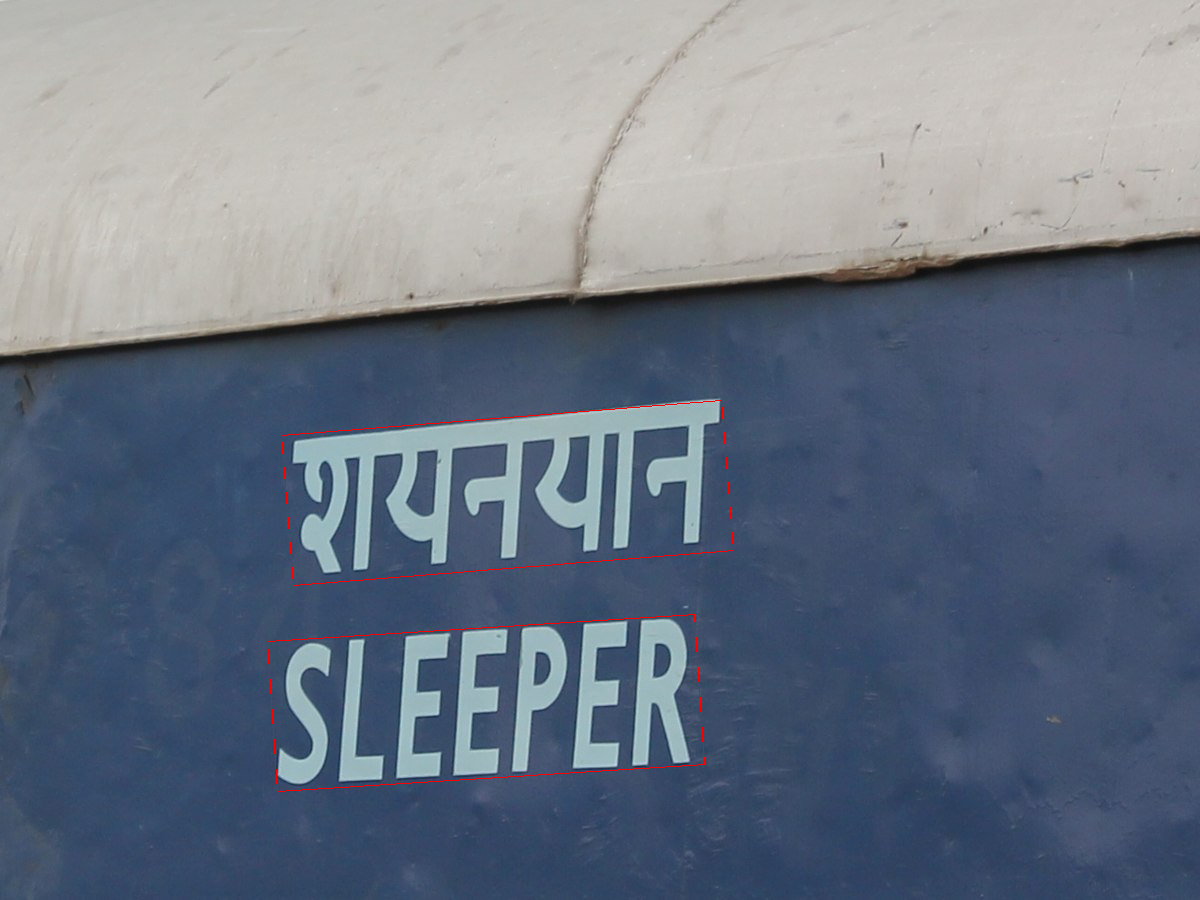

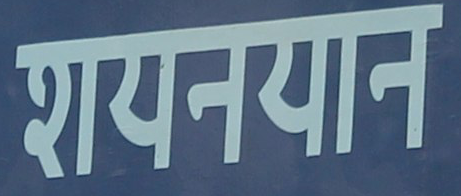

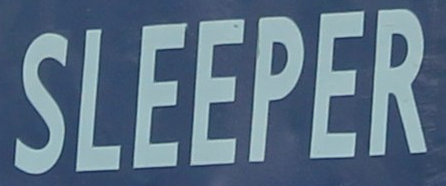

In [64]:
img_pil, cropped_imgs = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

for cropped_img in cropped_imgs:
    display(cropped_img)

## 05_3. Recognition

In [85]:
def recognize_img(pil_img, input_img_size=(100,32),show_img = False):
    # Prepare the image
    width, height = pil_img.size
    target_height = input_img_size[1]
    target_width = min(int(width * target_height / height), input_img_size[0])
    target_img_size = (target_width, target_height)
    img = pil_img.resize(target_img_size)
    img = np.array(img)
    img = img.transpose(1,0,2)

    input_images = np.zeros((1, input_img_size[0], input_img_size[1], 3), dtype='float32')
    input_images[0, :target_width, :, :] = img 

    y_pred = model_pred.predict(input_images)

    result = decode_predict_ctc(y_pred, chars='-'+TARGET_CHARACTERS)[0].replace('-','')
    # 결과 후처리
    import re
    result = re.sub(r'\d+$', '', result)
    print("Recognized Text: \t", result)
    if show_img == True : display(pil_img)
    return result

### recognition result

Recognized Text: 	 RARIN


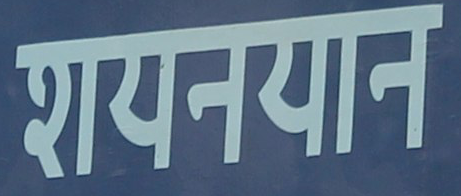

Recognized Text: 	 SLEEPER


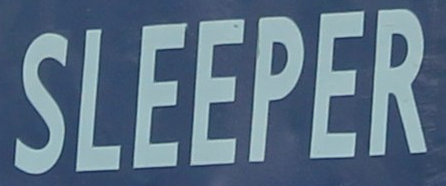

In [87]:
# 결과 출력
for _img in cropped_imgs:
    recognize_img(_img,show_img=True)


# 06. End-to-End OCR

In [119]:
def result(PATH,show_img=False):
    img_pil, cropped_imgs = detect_text(PATH)
    if show_img == True : display(img_pil)
    for _img in cropped_imgs:
        result = recognize_img(_img,show_img=show_img) 

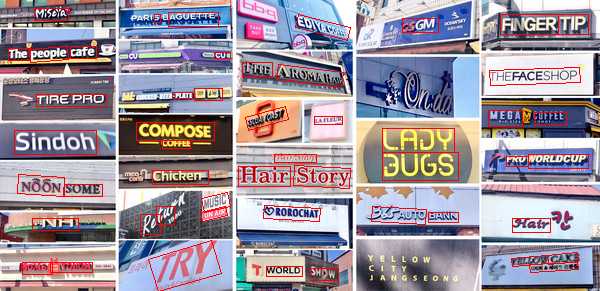

Recognized Text: 	 CLMISCAN


Recognized Text: 	 ENOEN


Recognized Text: 	 IN


Recognized Text: 	 THONGES


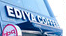

Recognized Text: 	 IFINGERS


Recognized Text: 	 LCUIP


Recognized Text: 	 PGMN


Recognized Text: 	 CAFEN


Recognized Text: 	 IHER


Recognized Text: 	 PEOPLES


Recognized Text: 	 ACUK


Recognized Text: 	 TUES


Recognized Text: 	 AROMIN


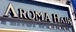

Recognized Text: 	 THEFACESHOP


Recognized Text: 	 KCE


Recognized Text: 	 DIAINLI


Recognized Text: 	 TIAEPAO


Recognized Text: 	 IMNON


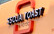

Recognized Text: 	 MEGAS


Recognized Text: 	 SUARFEEN


Recognized Text: 	 ILANNS


Recognized Text: 	 COUPOSE


Recognized Text: 	 LIGNS


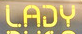

Recognized Text: 	 ISINDOH


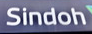

Recognized Text: 	 TONNETS


Recognized Text: 	 DRAOEIAON


Recognized Text: 	 SLIGS


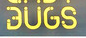

Recognized Text: 	 CIMNORLOGUER


Recognized Text: 	 PERON


Recognized Text: 	 CHAIE


Recognized Text: 	 ESCOVV


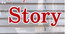

Recognized Text: 	 LICHICKERES


Recognized Text: 	 INOONS


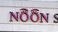

Recognized Text: 	 ISOME


Recognized Text: 	 LMACL


Recognized Text: 	 OROFOGUNTY


Recognized Text: 	 GIOG


Recognized Text: 	 SMNOCLY


Recognized Text: 	 UNUIES


Recognized Text: 	 ENKY


Recognized Text: 	 ROD


Recognized Text: 	 SSSNIAIS


Recognized Text: 	 SATRS


Recognized Text: 	 IRY


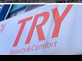

Recognized Text: 	 RCXE


Recognized Text: 	 VDENS


Recognized Text: 	 AMOROIY


Recognized Text: 	 MIONE


Recognized Text: 	 MAACH


Recognized Text: 	 TWORLD


Recognized Text: 	 ISMWDWLY


In [120]:
result(HOME_DIR + '/tag.jpg',show_img=True)

In [121]:
result(HOME_DIR + '/HANOI.jpg')

Recognized Text: 	 NME
Recognized Text: 	 OUA
Recognized Text: 	 IDOIEMIONG
Recognized Text: 	 NORIGINAL
Recognized Text: 	 MANON
Recognized Text: 	 OISED
Recognized Text: 	 JULSANS
Recognized Text: 	 RSAMSANS
Recognized Text: 	 IYSTORE
Recognized Text: 	 SCHIAMZEN
Recognized Text: 	 SROOE
Recognized Text: 	 TOTETIMY
Recognized Text: 	 CUAE
Recognized Text: 	 FECOMLIW


# 07. Comparison OCR 
## (Tesseract,keras_ocr, keras_ocr_detector + RCNN recognition)

In [94]:
!pip install pytesseract

In [116]:
import pytesseract
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2

def tesseract_ocr_with_boxes(image_path):
    img = Image.open(image_path)
    data = pytesseract.image_to_data(img, lang='eng', output_type=pytesseract.Output.DICT)
    return data, img

def show_tesseract_result_with_boxes(data, img):
    draw = ImageDraw.Draw(img)

    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 0: 
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            draw.rectangle([(x, y), (x + w, y + h)], outline="red", width=2)
            draw.text((x, y - 10), data['text'][i], fill=(255, 0, 0)) 

    return img

def show_tesseract_result(image_path, result_text):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)

    # 이미지에 결과 텍스트 추가
    draw.text((10, 10), result_text, fill=(255, 0, 0))

    return img

In [117]:
import keras_ocr

# Keras-OCR 함수
def keras_ocr_process(image_path):
    pipeline = keras_ocr.pipeline.Pipeline()
    image = keras_ocr.tools.read(image_path)
    prediction_groups = pipeline.recognize([image])

    return prediction_groups, image

# Keras-OCR 바운딩 박스 그리기
def show_keras_ocr_result(prediction_groups, image):
    image_with_boxes = image.copy()

    # 바운딩 박스 그리기
    for prediction in prediction_groups[0]:
        text, box = prediction
        box = box.astype(int)
        cv2.polylines(image_with_boxes, [box], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.putText(image_with_boxes, text, (box[0][0], box[0][1] - 10),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 255, 0), thickness=2)

    return image_with_boxes

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


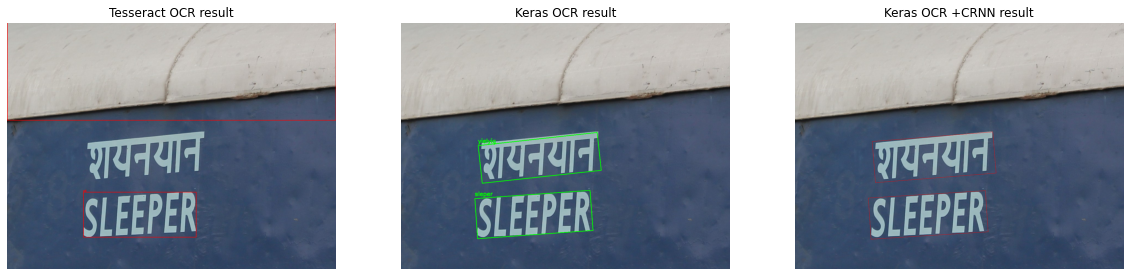

Tesseract OCR Result:  

qavat
ad

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5

Keras OCR Result:
Detected Text: yielyig
Detected Text: sleper


Keras OCR + CRNN Result
Recognized Text: 	 RARIN
Recognized Text: 	 SLEEPER


In [125]:
# 이미지 파일 경로
image_path = HOME_DIR + '/data/sample.jpg'

def comparison(image_path):
    # 1. Tesseract OCR 결과 바운딩 박스 확인
    tesseract_data, tesseract_img = tesseract_ocr_with_boxes(image_path)
    tesseract_image_with_boxes = show_tesseract_result_with_boxes(tesseract_data, tesseract_img)

    # 2. Keras-OCR 결과 확인 및 시각화
    keras_prediction, keras_image = keras_ocr_process(image_path)
    keras_ocr_image = show_keras_ocr_result(keras_prediction, keras_image)

    # 3. Keras-OCR + CRNN 결과 확인 및 시각화
    img_pil, cropped_imgs = detect_text(image_path)

    plt.figure(figsize=(20, 10))

    # Tesseract 결과
    plt.subplot(1, 3, 1)
    plt.imshow(tesseract_image_with_boxes)
    plt.title("Tesseract OCR result")
    plt.axis("off")

    # Keras OCR 결과
    plt.subplot(1, 3, 2)
    plt.imshow(keras_ocr_image)
    plt.title("Keras OCR result")
    plt.axis("off")

    # Keras OCR 결과
    plt.subplot(1, 3, 3)
    plt.imshow(img_pil)
    plt.title("Keras OCR +CRNN result")
    plt.axis("off")

    # 이미지 보여주기
    plt.show()


    tesseract_result = tesseract_ocr(image_path)
    print("Tesseract OCR Result:", tesseract_result)
    tesseract_image = show_tesseract_result(image_path, tesseract_result)

    keras_prediction, keras_image = keras_ocr_process(image_path)
    print("\nKeras OCR Result:")
    for text, box in keras_prediction[0]:
        print(f"Detected Text: {text}")
    print("\n\nKeras OCR + CRNN Result")
    result(image_path)
    
comparison(image_path)

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


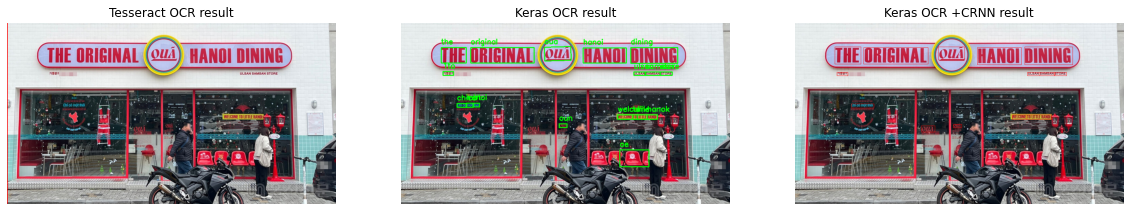

Tesseract OCR Result:  

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5

Keras OCR Result:
Detected Text: oua
Detected Text: the
Detected Text: original
Detected Text: dining
Detected Text: hanoi
Detected Text: 1to
Detected Text: ulsan
Detected Text: samsan
Detected Text: store
Detected Text: mot
Detected Text: thoi
Detected Text: chico
Detected Text: welcome
Detected Text: to
Detected Text: liile
Detected Text: hanok
Detected Text: oun
Detected Text: ae


Keras OCR + CRNN Result
Recognized Text: 	 NME
Recognized Text: 	 OUA
Recognized Text: 	 IDOIEMIONG
Recognized Text: 	 NORIGINAL
Recognized Text: 	 MANON
Recognized Text: 	 OISED
Recognized Text: 	 JULSANS
Recognized Text: 	 RSAMSANS
Recognized Text: 	 IYSTORE
Recognized Text: 	 SCHIAMZEN
Recognized Text: 	 SROOE
Recognized Text: 	 TOTETIMY
Recognized Text: 	 CUAE
Recognized Text: 	 FECOMLIW


In [127]:
comparison(HOME_DIR + '/HANOI.jpg')

# 결과 비교
### Tesseract OCR의 성능이 가장 낮게 나왔으며 detection 또한 아쉬움을 보였다. 이유는 텍스트의 위치를 감지하는 것이 아닌 전체 이미지에서 텍스트를 바로 추출하는 방식이므로 글자 크기가 작거나 배경이 복잡할 경우 detection 성능이 좋지 않다고 한다. 또한 문자를 추출할 때 이진화 기법을 사용하는 이유로 성능 저하 발생 가능성이 높다. 이를 해결하기 위한 이미지 전처리 단계가 중요하다고 한다.
### 이 반면에 keras ocr과 CRNN 을 결합한 방법은 텍스트를 감지하여 높은 detection을 보여주며 시퀀스를 이용한 연속적인 데이터 처리가 가능하여 보다 정확한 인식이 가능하였다. 따라서 복잡한 배경에서도 높은 정확도를 얻을 수 있음을 확인하였다. 그러나 문자 인식 부분에서는 여전히 아쉬움이 있었다. keras ocr만 사용한 경우에는 연속적으로 나오는 문자처리에 아쉬움이 있었다. 
### 반면에 직접 학습시킨 CRNN 모델 같은 경우에는 예측후 후처리 적용까지 직접 진행하여 keras 대비 높은 정확도의 결과를 얻을 수 있었으나 글자가 연속적으로 너무 붙어 있는 경우와 폰트가 학습한 폰트가 아닐경우에는 아쉬운 정확도를 보였다.
## 학습한 데이터량과 문자 추출 정확률은 비례할 것이다
## keras_ocr이 디텍션에서는 보다 정확한 결과를 얻을 수 있음을 확인하였다.또한 이미지 상에 text가 나와 보다 사용하기 편리할 것이라는 생각이 들었다.

# 고찰
### 더 많은 학습 데이터 수집과 전처리 및 일반화를 위한 증강 등 ->  더 많은 데이터 양에 어울리는 더욱 복잡도있고 일반화된 모델을 사용할 시 문자 추출의 정확도를 기대할 수 있을 것 같았다.
### 이러한 많은 OCR 종류로 Easy OCR, Google cloud vision ocr, Azure ocr등 많은 서비스가 있음을 확인 하였다. 이러한 많은 서비스들을 비교하며 이유를 찾아보면 성능을 높일 수 있을만한 결과를 찾는데 도움이 될것이라 생각하였다.